In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from src.etl import SugarData
import pathlib
import re
import statsmodels.formula.api as smf

from scipy.stats import linregress


init_notebook_mode(connected=True)

local_path = pathlib.Path().resolve()

GREY = "#a3a3a3"

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 30)

# Inro 
The purpose of the notebook to have a first look into the data 

# Read data

In [3]:
data = SugarData(local_path / "data" / "raw.csv")

INFO:root: __read_data [DONE], Resulting Data Shape=(2265, 19)
INFO:root: __clean_data [DONE], Resulting Data Shape=(2218, 3)
INFO:root: __glucose [DONE], Resulting Data Shape=(2031, 2)
INFO:root: __notes [DONE], Resulting Data Shape=(187, 14)
INFO:root: __glucose_resampled [DONE], Resulting Data Shape=(20095, 2)


In [4]:
print(f"Start Date: {data.cleaned['datetime'].min()}")
print(f"End Date: {data.cleaned['datetime'].max()}")

Start Date: 2021-01-29 08:45:00
End Date: 2021-02-12 08:37:00


In [5]:
print("Glucose Level Basic Stats:")
glucose_stats = data.glucose[["glucose_level"]].describe().T
display(glucose_stats)

Glucose Level Basic Stats:


,count,mean,std,min,25%,50%,75%,max
glucose_level,2031.0,5.697046,0.833977,4.2,5.1,5.5,6.1,10.4


# Show Raw Measurements in time

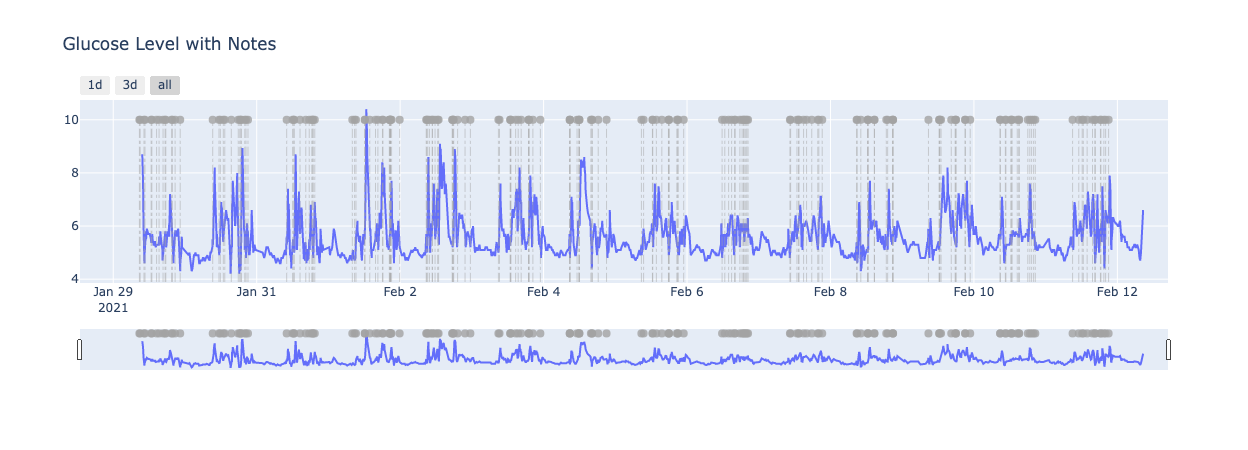

In [6]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=data.glucose["datetime"],
        y=data.glucose["glucose_level"],
        name="Glucose Level",
    )
)


# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1d", step="day", stepmode="backward"),
                    dict(count=3, label="3d", step="day", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=True),
        type="date",
    )
)
fig.update_layout(title="Glucose Level with Notes", showlegend=False)

# Add notes points
for n in data.notes.index:
    x = data.notes.loc[n, "datetime"]
    y = 10

    fig.add_shape(
        type="line",
        x0=x,
        y0=data.glucose.glucose_level.min() - 0.3,
        x1=x,
        y1=y,
        line=dict(
            color=GREY,
            width=0.5,
            dash="dashdot",
        ),
    )

    fig.add_trace(
        go.Scatter(
            x=[x],
            y=[10],
            text=[data.notes.loc[n, "notes"]],
            marker=dict(size=8, opacity=0.8, color=GREY),
        )
    )


fig.show()

- The highest glucose level was **10.4** after Banana; salad; turkey and potato. Value looks a bit too high.
- We have a lot of different kind of products and quite limited number of total notes. For simplicity we can split them on different groups

# Basic Analysis
Plan:
1. Calculate average intervals between food consumtion. **Findings**:
   - In %50% of cases I take next portion in less than 1 hour (49 minutes).
   - In ~25% of cases I take next portion within 15 minutes.
2. Calculate how fast sugar level increases to 6 or higher after consumtion if level is already higher than 6 or goes below we ignore such cases. 
   **Findings:**
   - In ~50% of cases sugar level increase to 6 and higher within ~ 20 minutes. Increase up to 8 took ~ 25 minutes

## 1. Average intervals between food consumption

In [7]:
notes_datetime = (
    data.notes.sort_values(by="datetime")
    .loc[:, ["datetime"]]
    .assign(
        minutes_from_previous_food=lambda d: (
            d["datetime"] - d["datetime"].shift(1)
        ).dt.seconds
        / 60
    )
)
notes_datetime[["minutes_from_previous_food"]].describe(
    percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
).T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
minutes_from_previous_food,186.0,104.61828,171.276541,0.0,3.25,6.0,14.0,49.0,114.25,193.0,598.0,841.0


## 2. Calculate how fast sugar level increases

In [8]:
glucose_with_notes = (
    pd.merge(data.glucose_resampled, data.notes, how="outer", on="datetime")
    .sort_values(by="datetime")
    .reset_index(drop=True)
)


def get_minutes_to_high_sugar(check_up_to_minutes: int, level_of_interest: int) -> None:
    minutes_to_high_sugar = []
    for i in glucose_with_notes.loc[glucose_with_notes["notes"].notnull()].index:
        if glucose_with_notes.loc[i, "glucose_level"] > level_of_interest:
            continue
        period_of_interest = glucose_with_notes.loc[i : i + check_up_to_minutes]

        index_with_high_level = period_of_interest.loc[
            lambda d: d["glucose_level"] > level_of_interest
        ].index

        # use first if available
        if len(index_with_high_level) > 0:
            minutes_to_high_sugar.append(index_with_high_level[0] - i)
    print("_______________")
    print(
        f"Check how fast sugar level increase within {check_up_to_minutes} minutes up to {level_of_interest}"
    )
    display(
        pd.DataFrame({"minutes_to_high_sugar": minutes_to_high_sugar})
        .describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])
        .T
    )
    return


get_minutes_to_high_sugar(check_up_to_minutes=30, level_of_interest=6)
get_minutes_to_high_sugar(check_up_to_minutes=60, level_of_interest=6)
get_minutes_to_high_sugar(check_up_to_minutes=120, level_of_interest=6)
get_minutes_to_high_sugar(check_up_to_minutes=30, level_of_interest=8)
get_minutes_to_high_sugar(check_up_to_minutes=60, level_of_interest=8)
get_minutes_to_high_sugar(check_up_to_minutes=120, level_of_interest=8)

_______________
Check how fast sugar level increase within 30 minutes up to 6


,count,mean,std,min,25%,50%,75%,90%,95%,max
minutes_to_high_sugar,81.0,16.604938,8.598952,1.0,10.0,18.0,24.0,27.0,27.0,30.0


_______________
Check how fast sugar level increase within 60 minutes up to 6


,count,mean,std,min,25%,50%,75%,90%,95%,max
minutes_to_high_sugar,102.0,21.205882,12.082504,1.0,13.0,21.0,27.0,37.9,42.9,48.0


_______________
Check how fast sugar level increase within 120 minutes up to 6


,count,mean,std,min,25%,50%,75%,90%,95%,max
minutes_to_high_sugar,118.0,29.271186,23.975294,1.0,15.0,23.0,36.75,66.3,84.15,117.0


_______________
Check how fast sugar level increase within 30 minutes up to 8


,count,mean,std,min,25%,50%,75%,90%,95%,max
minutes_to_high_sugar,17.0,18.529412,9.165954,1.0,11.0,20.0,27.0,27.4,28.2,29.0


_______________
Check how fast sugar level increase within 60 minutes up to 8


,count,mean,std,min,25%,50%,75%,90%,95%,max
minutes_to_high_sugar,25.0,25.44,13.03866,1.0,17.0,27.0,38.0,39.6,44.0,50.0


_______________
Check how fast sugar level increase within 120 minutes up to 8


,count,mean,std,min,25%,50%,75%,90%,95%,max
minutes_to_high_sugar,30.0,34.833333,24.794442,1.0,20.0,27.5,39.75,74.4,84.6,97.0


In [9]:
glucose_with_notes[:5]

,datetime,glucose_level,notes,notes_norm,activities,feelings,fruits,hot_drinks,salad,vegetables,fat,sweet,protein,carbs,alcohol
0,2021-01-29 08:45:00,NaN,Oatmeal; sweet dried berries,oatmeal; sweet dried berries,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,2021-01-29 09:00:00,NaN,Coffee,coffee,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-01-29 09:43:00,8.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-29 09:44:00,8.633333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-29 09:45:00,8.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Estimate Food Effect
**Plan:**
1. Try to calculate slope difference before food consumption and right after it within 20 min. If we we take the new portion within 20 min then we consider this period for slope calculation. **Findings:**
   - Top products by glucose increase do not make a lot of sense what can be related to the previous products consumed. The approach must be reconsidered
2. Check moment when glucose level increased up to 6, 7 or 8 and see what food was consumed -N- minutes before that. **Findings:**
   - An amount of data is quite limited, so it's hard to make final conclusions at that moment. 
   - Statistically significant effect on the sugar level increase was find only for Sweet products. Carbs affected the sugar level only when I used glucose_level_of_interest = 5.8. 

## 1. Slope change comparison

In [10]:
minutes_range = 20

# remove feelings
glucose_with_notes = (
    glucose_with_notes.loc[lambda d: d["feelings"] != 1]
    .drop("feelings", axis=1)
    .reset_index(drop=True)
)

notes_glucose_slope = glucose_with_notes.loc[lambda d: d["notes"].notnull()].copy()


def slope(X: pd.Series) -> pd.Series:
    X_slope = linregress([i for i in range(len(X))], X)[0]
    if np.isnan(X_slope):
        return 0.0
    return X_slope


notes_index = notes_glucose_slope.index
notes_glucose_slope["slope_diff"] = float("NaN")
for i in range(len(notes_index)):
    index_note = notes_index[i]  # index of the note for which we do prediction

    # select closest previous note or current note - 20 minutes
    if i != 0:
        index_start = max(notes_index[i - 1], index_note - minutes_range)
    else:
        index_start = index_note - minutes_range

    # select closest next note or current note + 20 minutes
    if i != len(notes_index) - 1:
        index_end = min(notes_index[i + 1], index_note + minutes_range)
    else:
        index_end = index_note + minutes_range

    slope_before = slope(
        glucose_with_notes.loc[index_start:index_note, "glucose_level"]
    )
    slope_after = slope(glucose_with_notes.loc[index_note:index_end, "glucose_level"])

    notes_glucose_slope.loc[index_note, "slope_diff"] = slope_after - slope_before

print("Top 10 Notes by slope increase:")
notes_glucose_slope.sort_values(by="slope_diff", ascending=False)[:10]

/Users/artem/workmaterials/various/sugar-level/venv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning:

invalid value encountered in sqrt



Top 10 Notes by slope increase:


,datetime,glucose_level,notes,notes_norm,activities,fruits,hot_drinks,salad,vegetables,fat,sweet,protein,carbs,alcohol,slope_diff
3047,2021-01-31 12:30:00,5.120000,Coffee small cup,coffee small cup,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.175725
5950,2021-02-02 12:52:00,5.708333,Gyokuro,gyokuro,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.151977
1981,2021-01-30 18:44:00,4.933333,Grapes,grapes,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145043
6254,2021-02-02 17:55:00,5.900000,chocolate,chocolate,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.140990
5713,2021-02-02 08:55:00,5.100000,1 pancake with creme fresh and framboise confi...,1 pancake with creme fresh and framboise confi...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.134308
4471,2021-02-01 12:14:00,5.655556,Banana,banana,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125119
14354,2021-02-08 08:56:00,4.600000,Coffee,coffee,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.117889
8585,2021-02-04 08:46:00,5.250000,Banana 1/2,banana 1/2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.112042
14427,2021-02-08 10:09:00,4.300000,Measurements look weird,measurements look weird,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109362
5879,2021-02-02 11:41:00,5.710000,Mandarin,mandarin,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103130


## 2. Check all consumed products before glucose increase
We check when glucose level increased up to **glucose_level_of_interest** and what we ate **minutes_of_interest** before that

In [11]:
def consumed_products_before_glucose_increase(
    glucose_level_of_interest: int, minutes_of_interest: int
) -> pd.DataFrame:
    return (
        glucose_with_notes.assign(
            # we do fillna with average glucose for first two notes before measurements started
            glucose_level=lambda d: d["glucose_level"].fillna(5.5)
        )
        # fillna the rest with -0-
        .fillna(0)
        .assign(
            abnormal_glucose_level=lambda d: np.where(
                d["glucose_level"] < glucose_level_of_interest, 0, 1
            ),
            was_previous_level_abnormal=lambda d: d["abnormal_glucose_level"].shift(1),
            glucose_switched_to_abnormal=lambda d: np.where(
                (d["abnormal_glucose_level"] == 1)
                & (d["was_previous_level_abnormal"] == 0),
                1,
                0,
            ),
            time_when_next_switch_happened=lambda d: np.where(
                d["glucose_switched_to_abnormal"] == 1,
                d["datetime"].astype(str),
                pd.NaT,
            ),
            glucose_when_next_switch_happened=lambda d: np.where(
                d["glucose_switched_to_abnormal"] == 1, d["glucose_level"], float("NaN")
            ),
        )
        .fillna(method="bfill")
        .assign(
            minutes_until_switch=lambda d: (
                d["time_when_next_switch_happened"] - d["datetime"]
            ).dt.seconds
            / 60
        )
        .loc[
            lambda d: d["minutes_until_switch"] <= minutes_of_interest,
            [
                "activities",
                "fruits",
                "hot_drinks",
                "salad",
                "vegetables",
                "fat",
                "sweet",
                "protein",
                "carbs",
                "alcohol",
                "time_when_next_switch_happened",
                "glucose_when_next_switch_happened",
            ],
        ]
        .groupby(
            ["time_when_next_switch_happened", "glucose_when_next_switch_happened"]
        )
        .sum()
        .reset_index()
    )


abt = consumed_products_before_glucose_increase(
    glucose_level_of_interest=6, minutes_of_interest=60
)

In [12]:
# fit OLS

import statsmodels.formula.api as smf


def calculate_ols(glucose_level_of_interest: int, minutes_of_interest: int) -> None:
    abt = consumed_products_before_glucose_increase(
        glucose_level_of_interest, minutes_of_interest
    )

    results = smf.ols(
        "glucose_when_next_switch_happened ~ activities+fruits+hot_drinks+salad+vegetables+fat+sweet+protein+carbs+alcohol",
        data=abt,
    ).fit()
    display(results.summary())


calculate_ols(glucose_level_of_interest=6, minutes_of_interest=60)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     glucose_when_next_switch_happened   R-squared:                       0.154
Model:                                           OLS   Adj. R-squared:                  0.065
Method:                                Least Squares   F-statistic:                     1.726
Date:                               Sun, 07 Mar 2021   Prob (F-statistic):             0.0860
Time:                                       15:33:49   Log-Likelihood:                -3.8396
No. Observations:                                106   AIC:                             29.68
Df Residuals:                                     95   BIC:                             58.98
Df Model:                                         10                                         
Covariance Type:                           nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0201      0.038    159.135      0.000       5.945       6.095
activities    -0.0237      0.126     -0.189      0.851      -0.273       0.226
fruits        -0.0174      0.045     -0.388      0.699      -0.107       0.072
hot_drinks     0.0535      0.065      0.823      0.413      -0.076       0.183
salad         -0.0900      0.166     -0.543      0.588      -0.419       0.239
vegetables     0.0359      0.092      0.389      0.698      -0.148       0.219
fat           -0.0707      0.087     -0.808      0.421      -0.244       0.103
sweet          0.2571      0.087      2.960      0.004       0.085       0.430
protein       -0.0115      0.085     -0.136      0.892      -0.179       0.156
carbs          0.0739      0.069      1.072      0.286      -0.063       0.211
alcohol        0.0370      0.085      0.437      0.663      -0.131       0.205
==============================================================================
Omnibus:                      188.095   Durbin-Watson:                   1.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18632.914
Skew:                           7.126   Prob(JB):                         0.00
Kurtosis:                      66.369   Cond. No.                         8.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
calculate_ols(glucose_level_of_interest=5.8, minutes_of_interest=60)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     glucose_when_next_switch_happened   R-squared:                       0.155
Model:                                           OLS   Adj. R-squared:                  0.082
Method:                                Least Squares   F-statistic:                     2.112
Date:                               Sun, 07 Mar 2021   Prob (F-statistic):             0.0288
Time:                                       15:33:49   Log-Likelihood:                -5.2739
No. Observations:                                126   AIC:                             32.55
Df Residuals:                                    115   BIC:                             63.75
Df Model:                                         10                                         
Covariance Type:                           nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8122      0.034    169.727      0.000       5.744       5.880
activities     0.0166      0.110      0.151      0.880      -0.201       0.234
fruits        -0.0142      0.049     -0.290      0.773      -0.111       0.083
hot_drinks     0.0226      0.069      0.327      0.744      -0.114       0.159
salad         -0.1238      0.146     -0.850      0.397      -0.412       0.165
vegetables    -0.0007      0.077     -0.009      0.993      -0.153       0.152
fat           -0.0658      0.073     -0.903      0.368      -0.210       0.079
sweet          0.2908      0.088      3.308      0.001       0.117       0.465
protein     -9.77e-05      0.080     -0.001      0.999      -0.158       0.158
carbs          0.1176      0.065      1.824      0.071      -0.010       0.245
alcohol       -0.0245      0.091     -0.268      0.789      -0.205       0.156
==============================================================================
Omnibus:                      217.244   Durbin-Watson:                   1.264
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26006.974
Skew:                           7.303   Prob(JB):                         0.00
Kurtosis:                      71.850   Cond. No.                         7.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
calculate_ols(glucose_level_of_interest=7, minutes_of_interest=60)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     glucose_when_next_switch_happened   R-squared:                       0.224
Model:                                           OLS   Adj. R-squared:                  0.012
Method:                                Least Squares   F-statistic:                     1.057
Date:                               Sun, 07 Mar 2021   Prob (F-statistic):              0.419
Time:                                       15:36:13   Log-Likelihood:                 1.9001
No. Observations:                                 43   AIC:                             16.20
Df Residuals:                                     33   BIC:                             33.81
Df Model:                                          9                                         
Covariance Type:                           nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0466      0.071     98.994      0.000       6.902       7.191
activities  4.311e-16   4.17e-17     10.336      0.000    3.46e-16    5.16e-16
fruits        -0.0172      0.065     -0.264      0.793      -0.149       0.115
hot_drinks     0.0400      0.099      0.405      0.688      -0.161       0.241
salad         -0.0617      0.301     -0.205      0.839      -0.673       0.550
vegetables    -0.1145      0.110     -1.045      0.304      -0.337       0.108
fat            0.0121      0.129      0.094      0.926      -0.251       0.275
sweet          0.2315      0.113      2.047      0.049       0.001       0.462
protein       -0.0240      0.124     -0.195      0.847      -0.275       0.227
carbs          0.0563      0.105      0.535      0.596      -0.158       0.270
alcohol       -0.0412      0.104     -0.396      0.695      -0.253       0.171
==============================================================================
Omnibus:                       73.653   Durbin-Watson:                   1.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1011.220
Skew:                           4.217   Prob(JB):                    2.61e-220
Kurtosis:                      25.210   Cond. No.                     3.92e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.87e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# TEMP

In [15]:
data.notes[:100]

,datetime,notes,notes_norm,activities,feelings,fruits,hot_drinks,salad,vegetables,fat,sweet,protein,carbs,alcohol
0,2021-01-29 08:45:00,Oatmeal; sweet dried berries,oatmeal; sweet dried berries,0,0,0,0,0,0,0,1,0,1,0
1,2021-01-29 09:00:00,Coffee,coffee,0,0,0,1,0,0,0,0,0,0,0
6,2021-01-29 10:17:00,Feel hungry,feel hungry,0,1,0,0,0,0,0,0,0,0,0
12,2021-01-29 10:37:00,Handful almonds,handful almonds,0,0,0,0,0,0,1,0,0,0,0
24,2021-01-29 12:41:00,Salad; buffalo mozzarella; tomato,salad; buffalo mozzarella; tomato,0,0,0,0,1,1,1,0,0,0,0
28,2021-01-29 12:55:00,Gyokuro,gyokuro,0,0,0,1,0,0,0,0,0,0,0
41,2021-01-29 14:30:00,Walk,walk,1,0,0,0,0,0,0,0,0,0,0
46,2021-01-29 15:20:00,mandarin,mandarin,0,0,1,0,0,0,0,0,0,0,0
59,2021-01-29 16:40:00,Pear,pear,0,0,1,0,0,0,0,0,0,0,0
65,2021-01-29 17:21:00,Yalla yalla; big portion; fat; bread,yalla yalla; big portion; fat; bread,0,0,0,0,0,0,1,0,1,1,0
